# Modules

In this notebook, we will discuss the various modules of GPAX to run various Gaussian process models.

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = ""

import jax
import jax.numpy as jnp
import jax.tree_util as jtu

import tensorflow_probability.substrates.jax as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

import matplotlib.pyplot as plt
import arviz as az

import gpax.kernels as gpk
import gpax.likelihoods as gpl
import gpax.models as gpm
from gpax.means import Scalar, Average

/home/patel_zeel/miniconda3/envs/jax_gpu/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: LOCAL is an invalid version and will not be supported in a future release
  warnings.warn(


## Kernels

Kernels are the building blocks of Gaussian process models. They are used to define the covariance function of the Gaussian process. The covariance function is a function of two inputs, $x$ and $x'$, and is provides the covariance (or similarity) between the two inputs.

### Common kernels

The most commonaly used kernel is Radial Basis Function (RBF) (or squared exponential) kernel, which is defined as:

$$
k(x, x') = \sigma^2 \exp\left(-\frac{1}{2l^2} (x - x')^2\right)
$$

We can define the RBF kernel in GPAX as follows with lengthscale ($\ell$) and variance ($\sigma^2$):

In [2]:
X = jnp.linspace(0, 1, 20).reshape(-1, 1)
lengthscale = jnp.array(0.1)
variance = jnp.array(0.5)

base_kernel = gpk.RBF(X, lengthscale=lengthscale)
kernel = variance * base_kernel
print(kernel)

2023-02-02 11:48:35.362648: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Scale(RBF)


A more explicit way to define the RBF kernel (or any other kernel with variance) is as follows:

In [3]:
base_kernel = gpk.RBF(X, lengthscale=lengthscale)
kernel2 = gpk.Scale(X, base_kernel, variance=variance)
print(kernel2)

Scale(RBF)


We can get the kernel function by calling the `get_kernel_fn` method. Optionally, for advanced kernels, `get_kernel_fn` takes `X_inducing` as in input. This is used for inducing point based kernels. While in `train` mode, kernel returns the covariance matrix and log prior. We will see more about the log prior later, but for common kernels, it is always `zero`.

In [4]:
kernel_fn = kernel.get_kernel_fn()
K, log_prior = kernel_fn(X, X)
print(K.shape, log_prior)

(20, 20) 0.0


Other common kernels are:
| Kernel | Formula |
| --- | --- |
| Matern 3/2 | $\sigma^2 \left(1 + \sqrt{3} \frac{d}{\ell}\right) \exp\left(-\sqrt{3} \frac{d}{\ell}\right)$ |
| Matern 5/2 | $\sigma^2 \left(1 + \sqrt{5} \frac{d}{\ell} + \frac{5}{3} \frac{d^2}{\ell^2}\right) \exp\left(-\sqrt{5} \frac{d}{\ell}\right)$ |
| Matern 1/2 or Exponential | $\sigma^2 \exp\left(- \frac{d}{\ell}\right)$ |
| Periodic | $\sigma^2 \exp\left(- \frac{2 \sin^2(\pi d / p)}{\ell}\right)$ |

In [5]:
lengthscale = jnp.array(0.1)

matern32 = variance * gpk.Matern32(X, lengthscale)
matern12 = variance * gpk.Matern12(X, lengthscale)
matern52 = variance * gpk.Matern52(X, lengthscale)
periodic = variance * gpk.Periodic(X, lengthscale, period=jnp.array(0.2))

### Special kernels

We have implemented various special kernels for research purposes. 

#### Input-dependent variance ($\sigma^2$) kernel

In cases, where we want to learn the variance of the kernel as a function of the input, we can use the `InputDependentScale` kernel. It takes a `base_kernel` and a `latent_model` as input. Latent models are discussed in detail in [Latent models](latent-models) section.

In [6]:
latent_kernel = variance * gpk.RBF(X, lengthscale=0.1)
latent_model = gpm.LatentGPHeinonen(X, latent_kernel)

base_kernel = gpk.RBF(X, lengthscale=0.2)
kernel = gpk.InputDependentScale(X, base_kernel, latent_model)
print(kernel)

InputDependentScale(RBF)


Let us plot the input-dependent variance ($\sigma^2$).

In [7]:
def plot_kernel():
    variable_scale, _ = kernel.latent_model(X_inducing=X)(X=X)
    variable_variance = variable_scale ** 2

    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax[0].plot(X, variable_variance, label='constant variance');

    K, log_prior = kernel.get_kernel_fn(X_inducing=X)(X, X)

    ax[1].imshow(K);
    return ax

Fixing a constant variance for all inputs. This could be a good initialization for the input-dependent variance kernel.

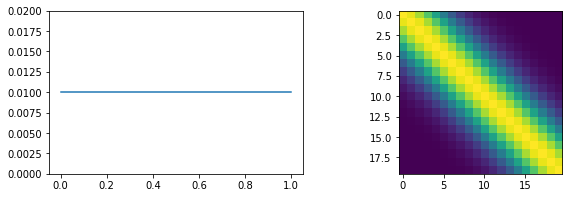

In [8]:
kernel.latent_model.reverse_init(jnp.array(0.1))
ax = plot_kernel()
ax[0].set_ylim(0, 0.02);

Randomizing the variance for all inputs:

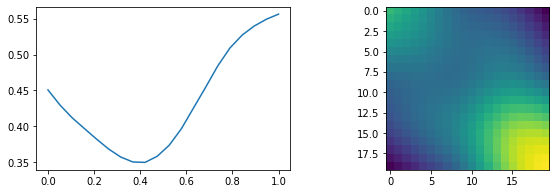

In [9]:
key = jax.random.PRNGKey(10)
kernel.initialize(key)
plot_kernel();

## Models

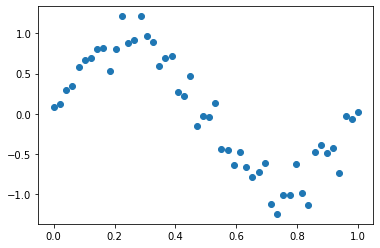

In [10]:
X = jnp.linspace(0, 1, 50).reshape(-1, 1)
X_test = jnp.linspace(0, 1, 100).reshape(-1, 1)
key = jax.random.PRNGKey(10)
y = (jnp.sin(2 * jnp.pi * X) + jax.random.normal(key, X.shape) * 0.2).squeeze()

plt.scatter(X, y);

In [11]:
kernel = jnp.array(1.0) * gpk.RBF(X, lengthscale=jnp.array(0.1))
model = gpm.ExactGPRegression(kernel, gpl.Gaussian(scale=jnp.array(1.0)), Scalar(value=jnp.array(0.0)))
key = jax.random.PRNGKey(0)
keys = jax.random.split(key, 5)

def fit_fn(key):
    # model.fit(key, X, y, lr=0.01, epochs=100)
    return model

models = jax.vmap(fit_fn)(keys)

# pred_mean, pred_cov = model.predict(X, y, X_test)

# plt.scatter(X, y)
# plt.plot(X_test, pred_mean, color='red');
# plt.fill_between(
#     X_test.squeeze(),
#     pred_mean - 2 * jnp.sqrt(pred_cov.diagonal()),
#     pred_mean + 2 * jnp.sqrt(pred_cov.diagonal()),
#     color='red',
#     alpha=0.2,
# );
# jtu.tree_leaves(models)

ValueError: vmap out_axes specification must be a tree prefix of the corresponding value, got specification 0 for value tree PyTreeDef(CustomNode(ExactGPRegression[(PyTreeDef({'kernel': {'base_kernel': {'lengthscale': *}, 'variance': *}, 'likelihood': {'scale': *}, 'mean': {'value': *}}), Scale(RBF), <gpax.likelihoods.Gaussian object at 0x7fae8c67a520>, <gpax.means.Scalar object at 0x7fae942a9310>)], [*, *, *, *])).

(latent-models)=
### Latent Models

In [ ]:
@jtu.register_pytree_node_class
class Special:
  def __init__(self, x, y):
    print("init", type(x))
    self.x = x
    self.y = y
  def tree_flatten(self):
    return ((self.x, self.y), self)
  @classmethod
  def tree_unflatten(cls, aux, children):
    print("unflatten", type(children[0]))
    return Special(*children)

def get_it(x, y):
    a = Special(x, y)
    a.x, a.y = x, y
    return a

a = jax.vmap(get_it)(jnp.arange(3)*1.0, jnp.arange(3)*1.0)
jtu.tree_flatten(a)

init <class 'jax.interpreters.batching.BatchTracer'>
unflatten <class 'object'>
init <class 'object'>
unflatten <class 'jaxlib.xla_extension.DeviceArray'>
init <class 'jaxlib.xla_extension.DeviceArray'>


([DeviceArray([0., 1., 2.], dtype=float32, weak_type=True),
  DeviceArray([0., 1., 2.], dtype=float32, weak_type=True)],
 PyTreeDef(CustomNode(Special[<__main__.Special object at 0x7f629c781f40>], [*, *])))